# Ensemble

In [1]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging

import numpy as np
import pandas as pd
from IPython.display import Image, display
from lightgbm.sklearn import LGBMRegressor
from matplotlib import pyplot as plt
from skfin.backtesting import Backtester
from skfin.datasets_ import load_kf_returns
from skfin.estimators import MLPRegressor, MultiOutputRegressor, RidgeCV
from skfin.metrics import sharpe_ratio
from skfin.mv_estimators import MeanVariance
from skfin.plot import bar, line
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from tqdm.auto import tqdm

logging.getLogger("skfin.datasets").setLevel(logging.CRITICAL)

returns_data = load_kf_returns(cache_dir="data")
ret = returns_data["Monthly"]["Average_Value_Weighted_Returns"][:"1999"]

transform_X = lambda x: x.rolling(12).mean().fillna(0)
transform_y = lambda x: x.shift(-1)
X = transform_X(ret)
y = transform_y(ret)

INFO:skfin.dataloaders.cache:Loading from cache : data/12_Industry_Portfolios


In previous sections (e.g. on hyperparameter tuning), we have described strategies to identify the best parameters for a given objective. In this section, rather than choosing a single estimator (or set of parameters) among many, we describe how to combine all multiple strategies. More precisely, the differences across strategies might be due to: 

- different hyperparameters; 

- different estimators;  

- different data inputs. 


Combination of strategies that are not perfectly correlated is actually powerful because it exploits gains from diversification. To combine weights, there are two setups: 

1. either the weights are known

2. or they need to be learned. 

In Finance (and more generally in Data Science), the "known weights" case is generally very strong, often as the equal-weight "1-over-N" baseline. This is generally due to the fact that in setups with a lot of noise, learning the weights is hard. In a latter section below, we introduce a setup with "learned weights": the main challenge is that the weights have to be learned over rolling windows (jointly with the derivation of the individual strategy positions). 

## Ensemble with scikit-learn

In the spirit of this course, we first use `scikit-learn` to combine strategy with known weights, in particular, the `VotingRegressor` class.

Disclaimer: I have found that using these `Ensemble` classes from `scikit-learn` is quite cumbersome (see also the `StackingRegressor`), in particular because these classes do not interact well with `scikit-learn` pipelines. 

In [2]:
from skfin.estimators import Ridge
from sklearn.ensemble import VotingRegressor


class VotingRegressor(VotingRegressor):
    def transform(self, X):
        return self.predict(X)

In [3]:
estimators_ = [
    ("ridge1", Ridge(alpha=1)),
    ("ridge2", Ridge(alpha=100)),
]

By default, `VotingRegressor` applies equal weights across regressors. 

In [4]:
pnls0 = pd.concat(
    {
        k: Backtester(
            make_pipeline(StandardScaler(with_mean=False), v, MeanVariance())
        ).train(X, y, ret)
        for k, v in estimators_
    },
    axis=1,
)

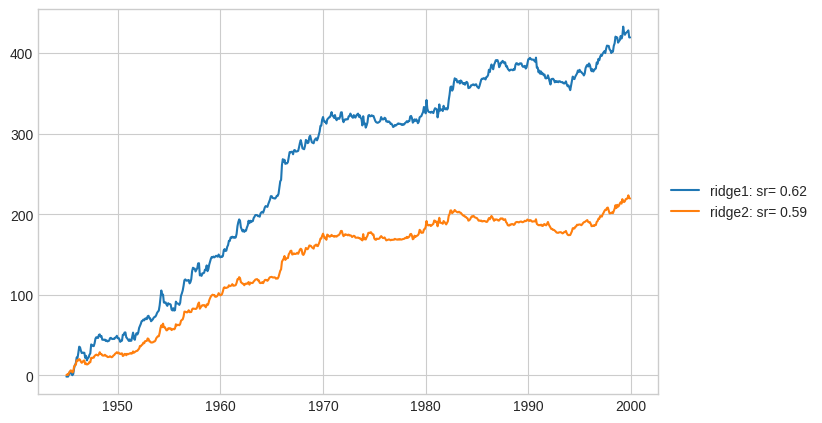

In [5]:
line(pnls0, cumsum=True)

In [6]:
estimator = make_pipeline(
    StandardScaler(with_mean=False),
    MultiOutputRegressor(VotingRegressor(estimators=estimators_)),
    MeanVariance(),
)

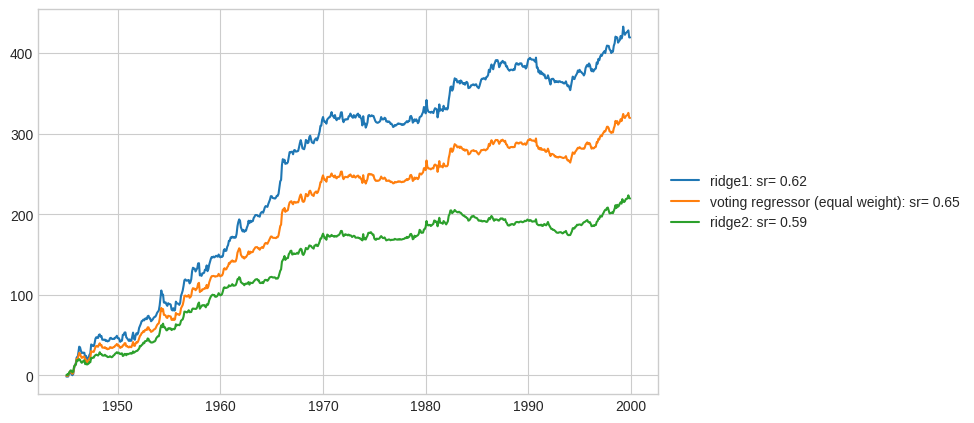

In [7]:
pnls0["voting regressor (equal weight)"] = Backtester(estimator).train(X, y, ret)
line(pnls0, cumsum=True)

In [8]:
estimator2 = make_pipeline(
    StandardScaler(with_mean=False),
    MultiOutputRegressor(VotingRegressor(estimators=estimators_, weights=[5, 1])),
    MeanVariance(),
)

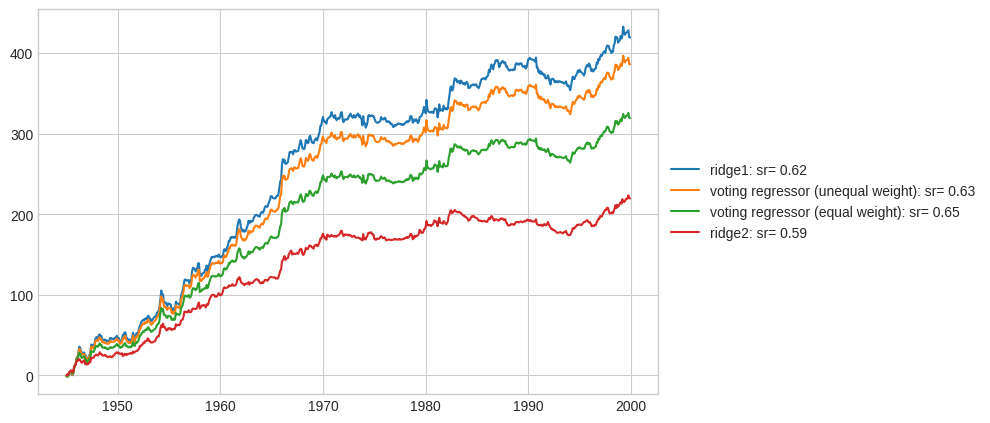

In [9]:
pnls0["voting regressor (unequal weight)"] = Backtester(estimator2).train(X, y, ret)
line(pnls0, cumsum=True)

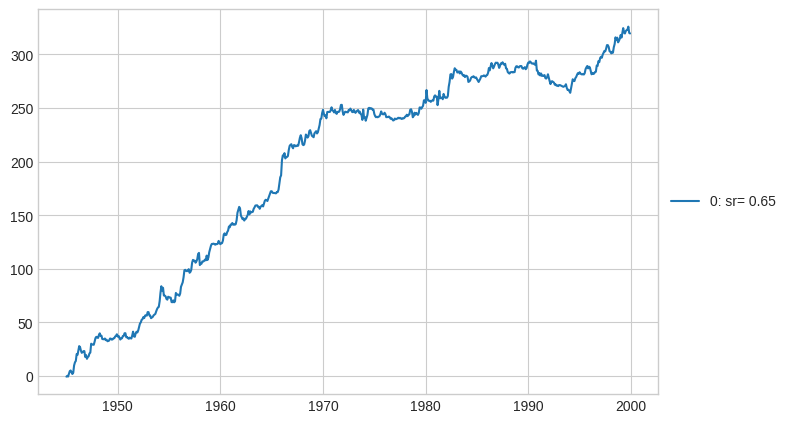

In [10]:
estimators_ = [
    ("ridge1", make_pipeline(StandardScaler(with_mean=False), Ridge(alpha=1))),
    ("ridge2", make_pipeline(StandardScaler(with_mean=False), Ridge(alpha=100))),
]

estimator = make_pipeline(
    MultiOutputRegressor(VotingRegressor(estimators=estimators_)),
    MeanVariance(),
)

pnl_ = Backtester(estimator).train(X, y, ret)
line(pnl_, cumsum=True)

## Rolling ensemble backtest

In this section, we build a custom ensemble method to learn weights on different estimators from pnls. 

### StackingBacktester

We consider three estimators: 
    
- the simple Industry momentum. 

- a strategy that learns cross-industry effect with `Ridge`. 

- a strategy that learns cross-industry effect with `Lightgbm`. 

In [11]:
estimators = {
    "momentum": MeanVariance(),
    "ridge": make_pipeline(StandardScaler(with_mean=False), Ridge(), MeanVariance()),
    "lightgbm": make_pipeline(
        MultiOutputRegressor(
            LGBMRegressor(min_child_samples=5, n_estimators=25, n_jobs=1)
        ),
        MeanVariance(),
    ),
}

In [12]:
pnls = pd.concat(
    {k: Backtester(v).train(X, y, ret) for k, v in estimators.items()},
    axis=1,
)

To construct an equal-weight strategy, we scale the sum of the pnl by the square-root of the number of strategy: 
    
$$pnl_{\text{equal weight}} = \frac{\sum_{n=1}^{n=N} pnl_n}{\sqrt{N}}.$$

In this case, if the individual pnls $pnl_n$ are identically and independently distributed (with the same standard deviation), then $pnl_{\text{equal weight}}$ has the same ex-ante standard deviation.  

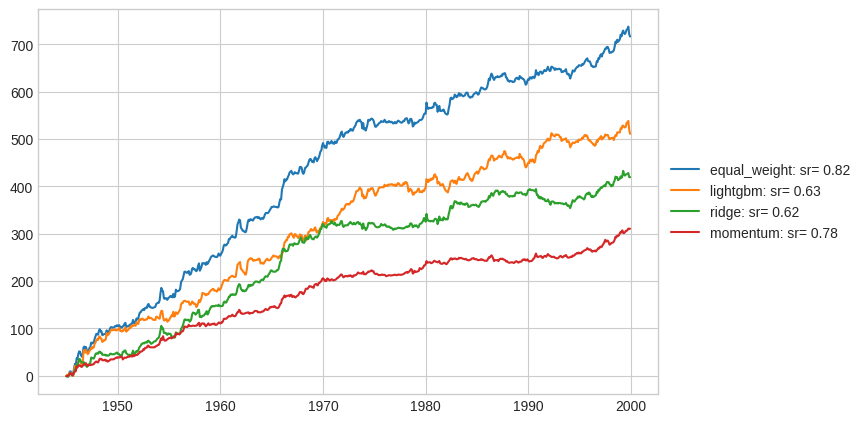

In [13]:
pnls_ = pnls.assign(equal_weight=lambda x: x.sum(axis=1).div(np.sqrt(x.shape[1])))
line(pnls_, cumsum=True)

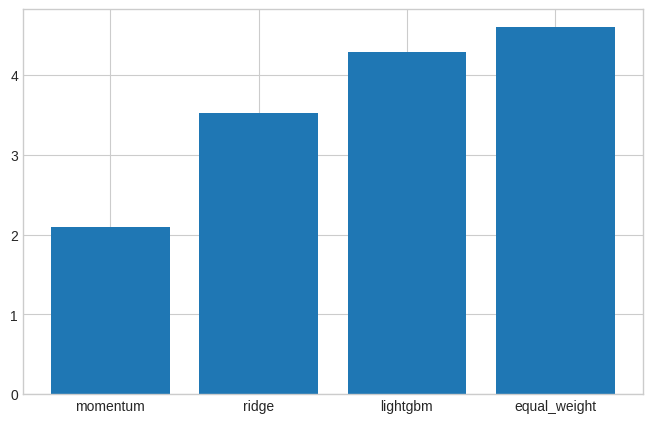

In [14]:
bar(pnls_.std())

The average correlation is not particularly high, which explains with some simple ensemble seems to help. 

In [15]:
print(
    f"The average pnl correlation between estimators is {pnls.corr().stack().loc[lambda x: x != 1].mean():.2f}"
)

The average pnl correlation between estimators is 0.45


We introduce a `StackingBacktester` with the `sklearn` API. 

In [16]:
%%writefile ../skfin/ensemble.py
from dataclasses import dataclass

import numpy as np
import pandas as pd
from skfin.mv_estimators import Mbj
from sklearn.base import BaseEstimator
from sklearn.model_selection import TimeSeriesSplit


@dataclass
class StackingBacktester:
    estimators: dict
    max_train_size: int = 36
    test_size: int = 1
    start_date: str = "1945-01-01"
    end_date: str = None
    window: int = 60
    min_periods: int = 60
    final_estimator: BaseEstimator = Mbj()

    def train(self, X, y, ret):
        cv = TimeSeriesSplit(
            max_train_size=self.max_train_size,
            test_size=self.test_size,
            n_splits=1 + len(X.loc[self.start_date : self.end_date]) // self.test_size,
        )
        N_estimators = len(self.estimators)
        cols = X.columns
        idx = X.index[np.concatenate([test for _, test in cv.split(X)])]

        _h = {k: [] for k in list(self.estimators.keys()) + ["ensemble"]}
        _next_pnls = {k: [] for k in self.estimators.keys()}
        _coef = []
        for i, (train, test) in enumerate(cv.split(X)):
            h_ = {}
            # each strategy position and next-period pnls 
            for k, m in self.estimators.items():
                m.fit(X.iloc[train], y.iloc[train])
                h_[k] = m.predict(X.iloc[test])
                _h[k] += [h_[k]]
                if i + 1 < len(idx):
                    _next_pnls[k] += [ret.loc[idx[i + 1]].dot(np.squeeze(h_[k]))]
            # compute coef from strategy pnls   
            if i <= self.min_periods:
                _coef += [np.zeros(N_estimators)]
            else:
                pnl_window = np.stack(
                    [np.array(v[-self.window-1 :-1]) for k, v in _next_pnls.items()], axis=1
                )
                coef_ = self.final_estimator.fit(pnl_window).coef_
                _coef += [coef_]                      
            # ensemble 
            if i <= self.min_periods:
                h_ensemble = np.zeros([len(cols), 1])
            else: 
                h_ensemble = (
                    np.stack([np.squeeze(v) for v in h_.values()], axis=1)
                    .dot(coef_)
                    .reshape(-1, 1)
                )
                V_ = m.named_steps["meanvariance"].V_
                h_ensemble = h_ensemble / np.sqrt(
                    np.diag(h_ensemble.T.dot(V_.dot(h_ensemble)))
                )                
            _h["ensemble"] += [h_ensemble.T]
            
        self.h_ = {
            k: pd.DataFrame(np.concatenate(_h[k]), index=idx, columns=cols)
            for k in _h.keys()
        }
        self.pnls_ = pd.concat(
            {
                k: v.shift(1).mul(ret).sum(axis=1)[self.start_date :]
                for k, v in self.h_.items()
            },
            axis=1,
        )
        self.coef_ = pd.DataFrame(
            np.stack(_coef), index=idx, columns=self.estimators.keys()
        )
        self.cv = cv 
        return self

Overwriting ../skfin/ensemble.py


In [17]:
from skfin.mv_estimators import Mbj

We first use the Britten-Jones (1999) trick (with the `Mbj` estimator) to compute the unconstrained mean-variance weigts over the full sample: 

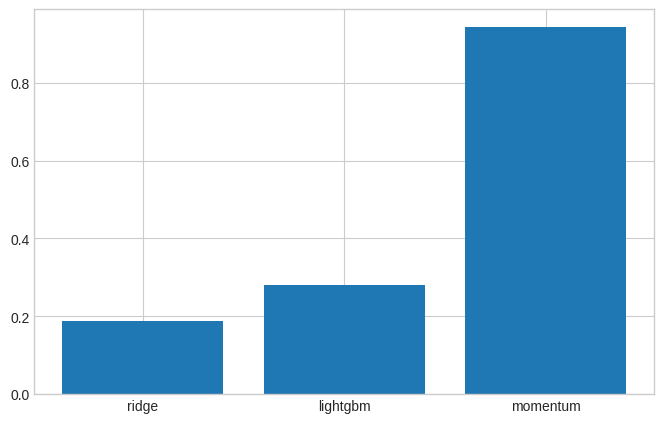

In [18]:
m = Mbj()
m.fit(pnls)
bar(pd.Series(m.coef_, index=pnls.columns))

These in-sample optimal weights improve even more the sharpe ratio -- but this is `in-sample`! 

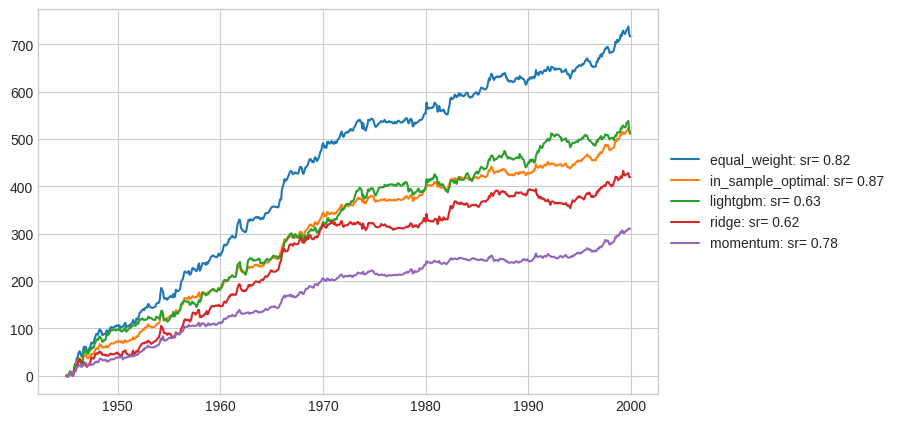

In [19]:
line(pnls_.assign(in_sample_optimal=Mbj().fit_transform(pnls)), cumsum=True)

The `StackingBacktester` computes the performance with the learned weights over rolling windows of 60 months (5 years). 

In [20]:
from skfin.ensemble import StackingBacktester

In [21]:
m = StackingBacktester(estimators=estimators, window=60, min_periods=60).train(
    X, y, ret
)
pnls = pnls.assign(ensemble_mbj=m.pnls_["ensemble"])

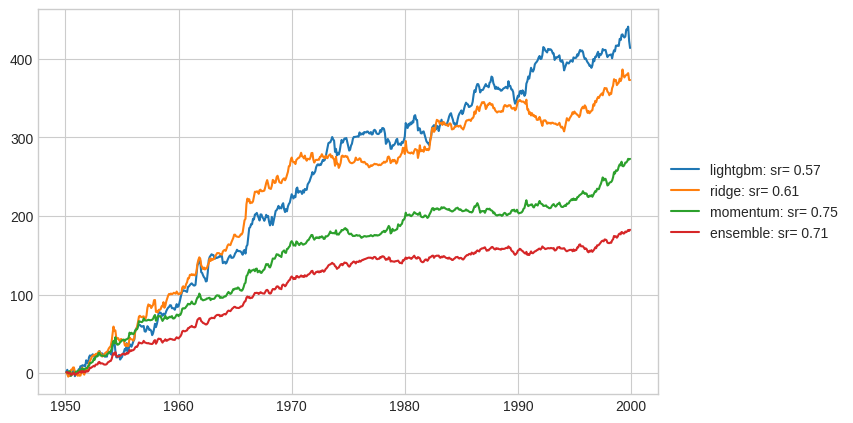

In [22]:
line(m.pnls_["1950-02-01":], cumsum=True)

To understand why the performance is lower, it is useful to look at the weights -- in this case, the weights are often negative. 

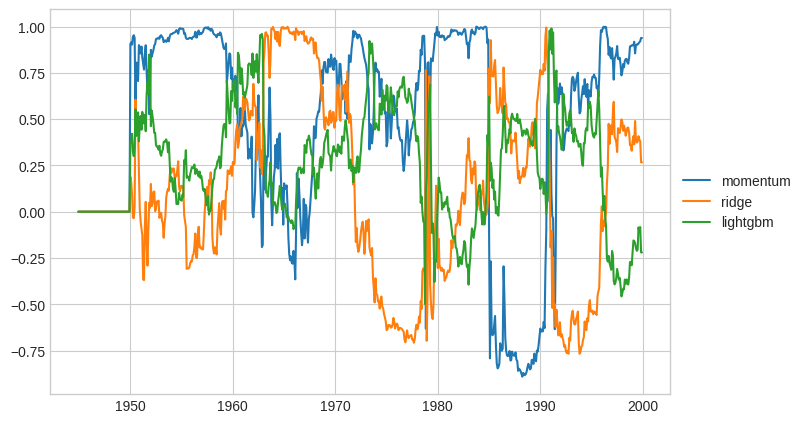

In [23]:
line(m.coef_)

We redo the exercise with a positive-weight constraint. 

In [24]:
from skfin.mv_estimators import Mbj

In [25]:
m = StackingBacktester(
    estimators=estimators,
    final_estimator=Mbj(positive=True),
    window=60,
    min_periods=60,
)
m.train(X, y, ret)
pnls["ensemble_mbj_positive"] = m.pnls_["ensemble"]

/home/schamponn/dev/projects/skfin/skfin/mv_estimators.py:139: RuntimeWarning: invalid value encountered in divide
  self.coef_ = m.coef_ / np.sqrt(np.sum(m.coef_**2))


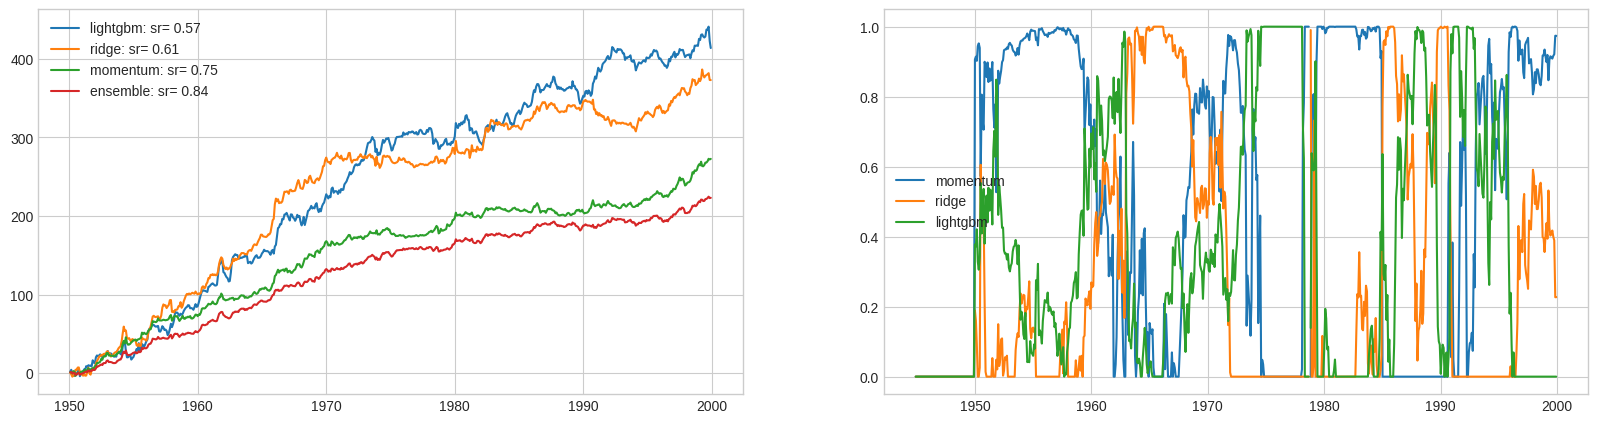

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
line(m.pnls_["1950-02-01":], cumsum=True, ax=ax[0], loc="best")
line(m.coef_, ax=ax[1], loc="best")

Over longer periods with positive constraints, the performance is closer to the industry momentum.

In [27]:
m = StackingBacktester(
    estimators=estimators,
    final_estimator=Mbj(positive=True),
    window=180,
    min_periods=60,
)
m.train(X, y, ret)
pnls["ensemble_mbj_positive_long_window"] = m.pnls_["ensemble"]

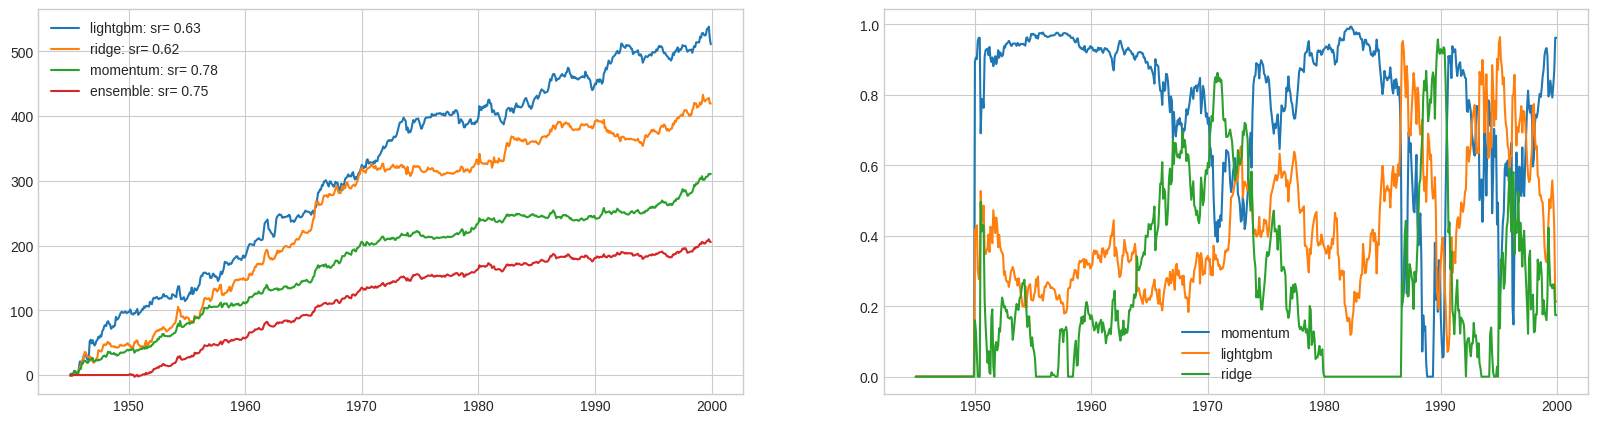

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
line(m.pnls_, cumsum=True, ax=ax[0], loc="best")
line(m.coef_, ax=ax[1], loc="best")

Putting the different ensembles, we compare the pnls in the graph below 

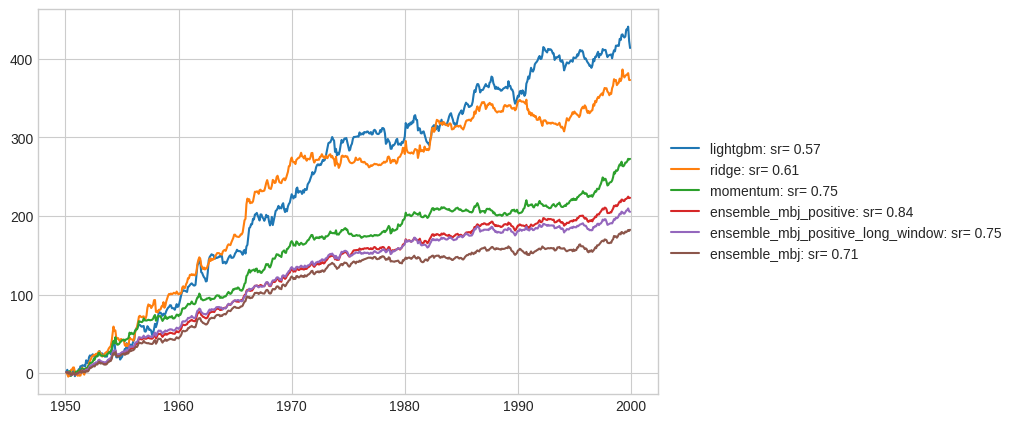

In [29]:
line(pnls["1950-02-01":], cumsum=True)